# Exploring of the LIAR dataset

In this jupyter notebook, the LIAR dataset from Wang 2017 (http://arxiv.org/abs/1705.00648) is explored. It is a dataset related to factual verification (final step of fake news detection) that is based on verdicts from PolitiFact.

This notebook looks at the distribution of the data, both in terms of words used, speakers, and verdicts.

## Import of modules

First, relevant Pyton modules are imported

In [31]:
%load_ext autoreload
%autoreload

from liar_utils import load_liar_dataset, LIARLabel, label_to_name
import seaborn as sns
from plotting_utils import dataframe_to_text, show_word_cloud
import os
import matplotlib.pyplot as plt

sns.set_theme()
data = load_liar_dataset("../data/LIAR")
data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,label,statement
id,,
2635.json,1,Says the Annies List political group supports ...
10540.json,3,When did the decline of coal start? It started...
324.json,4,"Hillary Clinton agrees with John McCain ""by vo..."
1123.json,1,Health care reform legislation is likely to ma...
9028.json,3,The economic turnaround started at the end of ...


## Wordclouds

Generate one wordcloud for the whole dataset, and one for each label

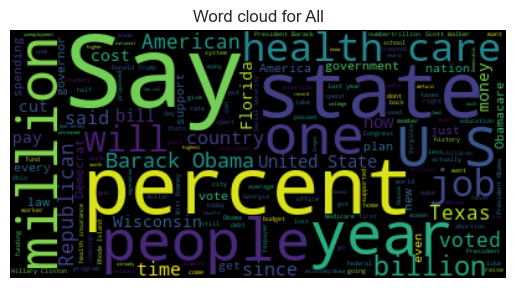

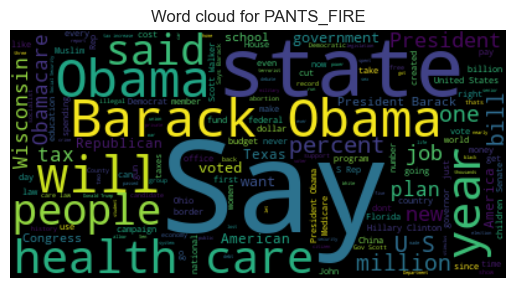

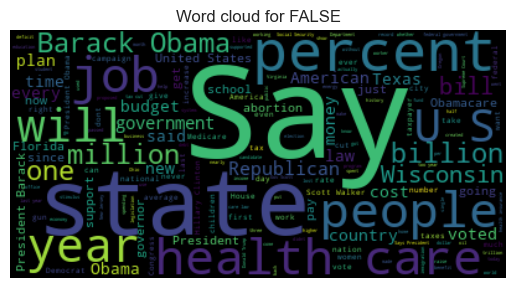

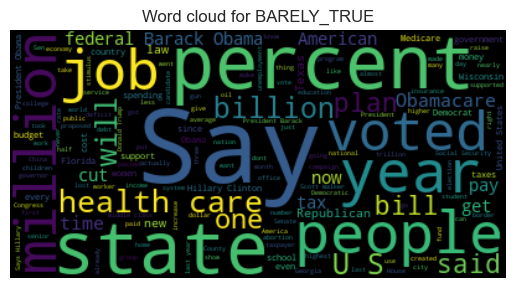

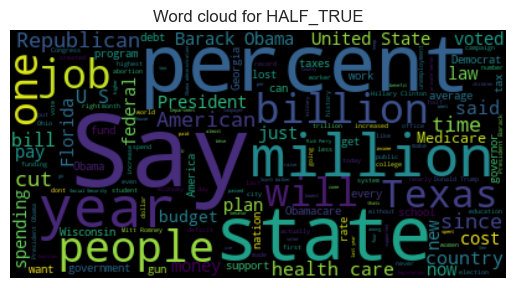

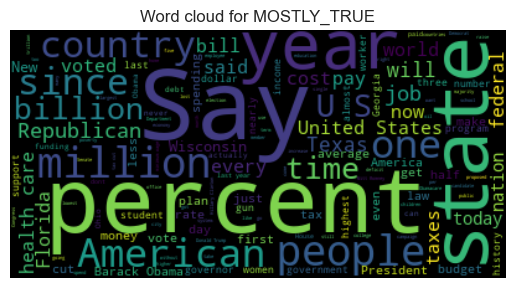

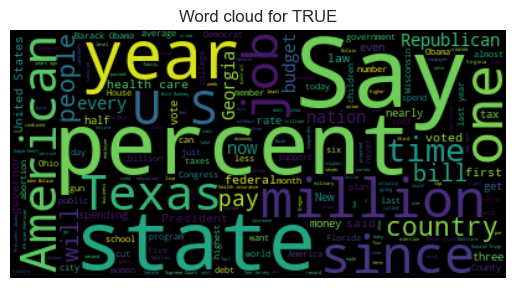

In [9]:
%autoreload
titles = ["All", *LIARLabel]
os.makedirs("../figures/liar/wordclouds", exist_ok=True)
for title in titles:
    if title == "All":
        text = dataframe_to_text(data, ["statement"])
    else:
        filtered_data = data[data["label"] == title.value]
        text = dataframe_to_text(filtered_data, ["statement"])
    title = f"Word cloud for {title.name if title != 'All' else 'All'}"
    save_path = f"../figures/liar/wordclouds/{title}.png"
    show_word_cloud(text, title, file_path=save_path)

## Label distributon

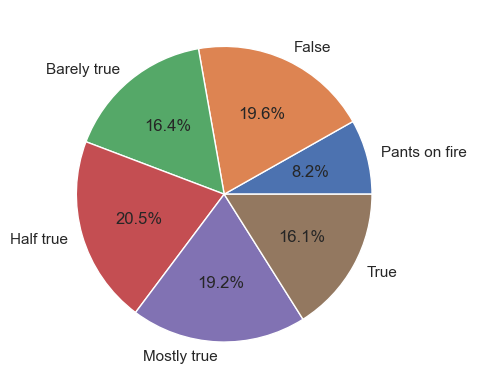

In [38]:
plt.pie(
    [data[data["label"] == label.value].shape[0] for label in LIARLabel],
    labels=[label_to_name(label) for label in LIARLabel],
    autopct="%.1f%%",
)
plt.savefig("../figures/liar/total_distribution.pdf")
plt.show()
